In [710]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(0)

The neural network designed for this classification task is structured to align with the input data, which consists of five distinct features. Accordingly, the input layer comprises five neurons, one for each feature.

The architecture incorporates three hidden layers, each with a custom number of neurons selected based on empirical tuning to optimize learning capacity while avoiding overfitting. This multi-layer structure enables the model to learn complex, non-linear relationships within the data.

Since the problem involves classification into five categories (labels 1 through 4), the output layer contains four neurons, each representing one class in a one-vs-rest format.

To enable training, the network initializes four sets of weights:
W_IH1: connects the input layer to the first hidden layer
W_H12: connects the first hidden layer to the second
W_H23: connects the second hidden layer to the third
W_H3O: connects the third hidden layer to the output layer

The forward propagation process is handled by a feedForward function, which passes inputs through each layer, applying the sigmoid activation function at each stage to compute intermediate and final outputs.

Backpropagation is used for training, where the network computes error gradients starting from the output layer and propagates them backward through the hidden layers. These gradients (deltas) are used to update the weights, minimizing prediction error over successive training epochs and improving the model’s performance.

In [712]:
class NeuralNetwork(object):
    def __init__(self):
        inputLayerNeurons = 5
        hiddenLayer1Neurons = 16
        hiddenLayer2Neurons = 36
        hiddenLayer3Neurons = 16
        outputLayerNeurons = 4

        self.W_IH1 = np.random.randn(inputLayerNeurons, hiddenLayer1Neurons)
        self.W_H12 = np.random.randn(hiddenLayer1Neurons, hiddenLayer2Neurons)
        self.W_H23 = np.random.randn(hiddenLayer2Neurons, hiddenLayer3Neurons)
        self.W_H3O = np.random.randn(hiddenLayer3Neurons, outputLayerNeurons)
        self.learning_rate = 0.01

    def sigmoid(self, x, der=False):
        if der == True:
          return x * (1 - x)
        else:
          return 1 / (1 + np.exp(-x))

    # Forward propagation to the parediction
    def feedForward(self, X):
        hidden1_input = np.dot(X, self.W_IH1)
        self.hidden1_output = self.sigmoid(hidden1_input)  # Getting output from hidden layer 1 neurons

        hidden2_input = np.dot(self.hidden1_output, self.W_H12)
        self.hidden2_output = self.sigmoid(hidden2_input)  # Getting output from hidden layer 2 neurons

        hidden3_input = np.dot(self.hidden2_output, self.W_H23)
        self.hidden3_output = self.sigmoid(hidden3_input) # Getting output from hidden layer 3 neurons

        output_input = np.dot(self.hidden3_output, self.W_H3O)
        pred = self.sigmoid(output_input) # Getting output from output layers

        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred # Error from the final output
        output_delta = output_error * self.learning_rate * self.sigmoid(pred, True)

        hidden3_error = output_delta.dot(self.W_H3O.T)  # Error from the hidden layer3
        hidden3_delta = hidden3_error * self.learning_rate * self.sigmoid(self.hidden3_output, True)

        hidden2_error = hidden3_delta.dot(self.W_H23.T) # Error from the hidden layer2
        hidden2_delta = hidden2_error * self.learning_rate * self.sigmoid(self.hidden2_output, True)

        hidden1_error = hidden2_delta.dot(self.W_H12.T) # Error from the hidden layer1
        hidden1_delta = hidden1_error * self.learning_rate * self.sigmoid(self.hidden1_output, True)

        # Adjusting the weights
        self.W_H3O += self.hidden3_output.T.dot(output_delta)
        self.W_H23 += self.hidden2_output.T.dot(hidden3_delta)
        self.W_H12 += self.hidden1_output.T.dot(hidden2_delta)
        self.W_IH1 += X.T.dot(hidden1_delta)


    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)

In [714]:
try:
    df = pd.read_csv('realistic_network_dataset.csv')
    X = df[['packet_size', 'inter_arrival_time', 'src_port', 'dst_port', 'protocol']].values
    Y_labels = df[['status']].values

    X_min = X.min(axis=0, keepdims=True)
    X_max = X.max(axis=0, keepdims=True)
    X_scaled = (X - X_min) / (X_max - X_min + 1e-8)

    # Adjust labels to be 0-indexed (0 to num_classes - 1)
    Y_labels_adjusted = Y_labels - 1
    num_classes = len(np.unique(Y_labels_adjusted))
    Y_onehot = np.eye(num_classes)[Y_labels_adjusted.flatten()]
    
except FileNotFoundError:
    print("Error: CSV file not found. Please upload the CSV file.")
    exit()

In [716]:
df.head()

,packet_size,inter_arrival_time,src_port,dst_port,protocol,status
0,61,17,95,73,56,3
1,24,16,26,68,75,4
2,81,76,80,65,47,3
3,70,26,98,68,60,2
4,30,42,54,79,72,4


In [718]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_scaled, Y_onehot, test_size=0.2, random_state=42)

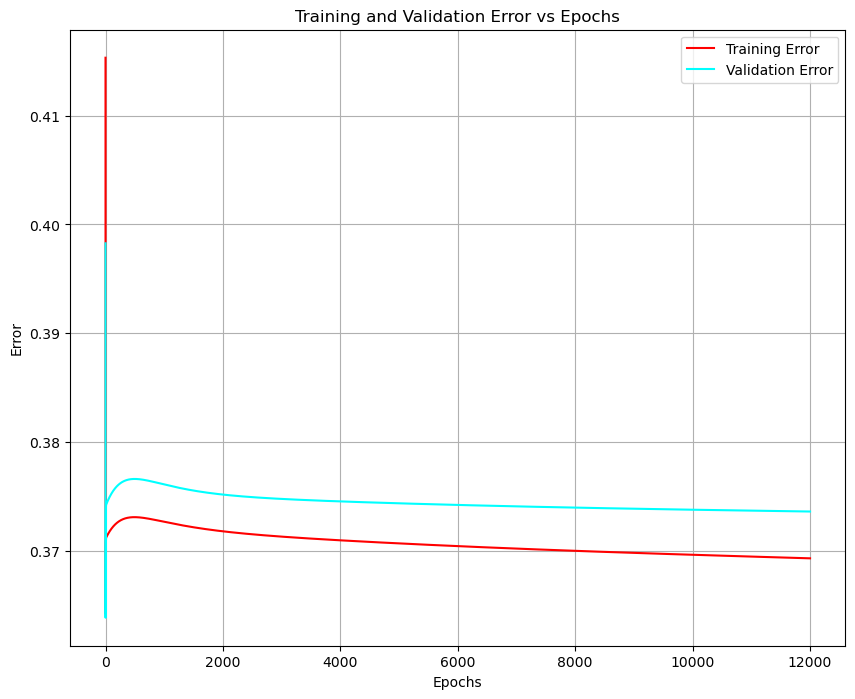

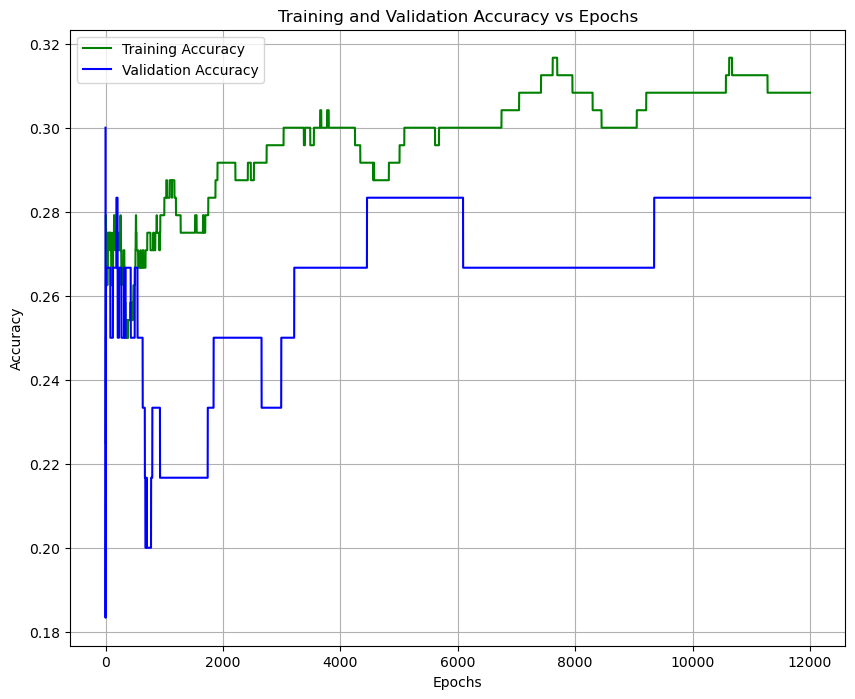

In [720]:
NN = NeuralNetwork()

train_err = []
val_err = []
train_acc = []
val_acc = []

for i in range(12000):
    NN.train(X_train, Y_train)

    # Training predictions and metrics
    train_output = NN.feedForward(X_train)
    train_loss = np.mean(np.abs(Y_train - train_output))
    train_err.append(train_loss)

    train_preds = np.argmax(train_output, axis=1)
    train_true = np.argmax(Y_train, axis=1)
    train_accuracy = np.mean(train_preds == train_true)
    train_acc.append(train_accuracy)

    # Validation predictions and metrics
    val_output = NN.feedForward(X_val)
    val_loss = np.mean(np.abs(Y_val - val_output))
    val_err.append(val_loss)

    val_preds = np.argmax(val_output, axis=1)
    val_true = np.argmax(Y_val, axis=1)
    val_accuracy = np.mean(val_preds == val_true)
    val_acc.append(val_accuracy)

# Plotting error
plt.figure(figsize=(10, 8))
plt.plot(train_err, label="Training Error", color="red")
plt.plot(val_err, label="Validation Error", color="cyan")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.title("Training and Validation Error vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy
plt.figure(figsize=(10, 8))
plt.plot(train_acc, label="Training Accuracy", color="green")
plt.plot(val_acc, label="Validation Accuracy", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


At the start of training, the model shows low accuracy on both the training and validation datasets, with training accuracy beginning around 0.27 and validation accuracy around 0.21. This indicates that the model initially struggles to distinguish between the output classes.
As training progresses over 10,000 epochs, the training accuracy shows a steady upward trend, reaching approximately 0.34. This suggests the model is successfully learning to better fit the training data. However, the validation accuracy tells a different story.
Validation accuracy fluctuates considerably in the early epochs and then settles into a flat pattern around 0.25, with little to no improvement beyond epoch 2000. This plateau, combined with the persistent gap between training and validation accuracy, strongly suggests underfitting. The model is not overfitting (as validation accuracy doesn’t drop), but it also isn’t generalizing well to unseen data.
The flat validation curve implies that training beyond a certain point offers no added benefit in terms of generalization. Applying early stopping around 2000–3000 epochs could make training more efficient.

In [721]:
top_50_df = pd.DataFrame({'Actual': val_true[:50], 'Predicted': val_preds[:50]})  # Taking top 50 for display

def color_mismatch(val):
    color = ['color: red;' if val['Actual'] != val['Predicted'] else 'color: black;'] * len(val)
    return pd.Series(color, index=val.index)

styled_df = top_50_df.style.apply(color_mismatch, axis=1)
display(styled_df)
     

,Actual,Predicted
0,0,3
1,3,3
2,0,2
3,0,3
4,2,3
5,1,3
6,1,2
7,3,3
8,2,1
9,1,3


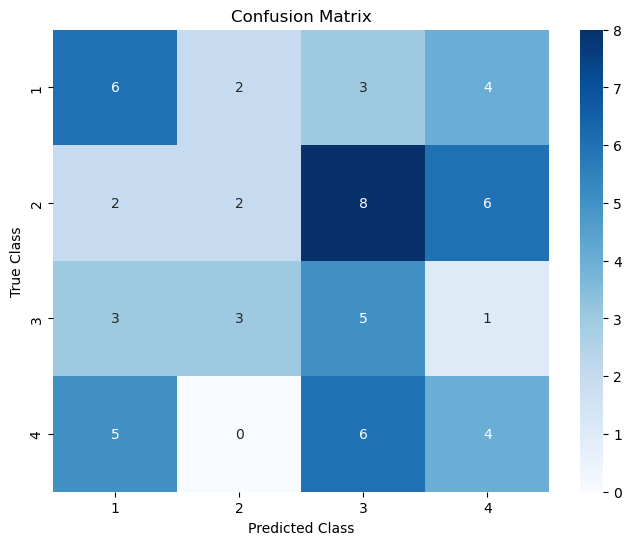

Macro-averaged F1 Score: 0.2770
Classification Report:

              precision    recall  f1-score   support

     Class 1       0.38      0.40      0.39        15
     Class 2       0.29      0.11      0.16        18
     Class 3       0.23      0.42      0.29        12
     Class 4       0.27      0.27      0.27        15

    accuracy                           0.28        60
   macro avg       0.29      0.30      0.28        60
weighted avg       0.29      0.28      0.27        60



In [722]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

val_output = NN.feedForward(X_val)
val_preds = np.argmax(val_output, axis=1)
val_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(val_true, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(1, 5), yticklabels=np.arange(1, 5))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

f1_macro = f1_score(val_true, val_preds, average='macro')
print(f"Macro-averaged F1 Score: {f1_macro:.4f}")

print("Classification Report:\n")
print(classification_report(val_true, val_preds, target_names=[f"Class {i}" for i in range(1, 5)]))

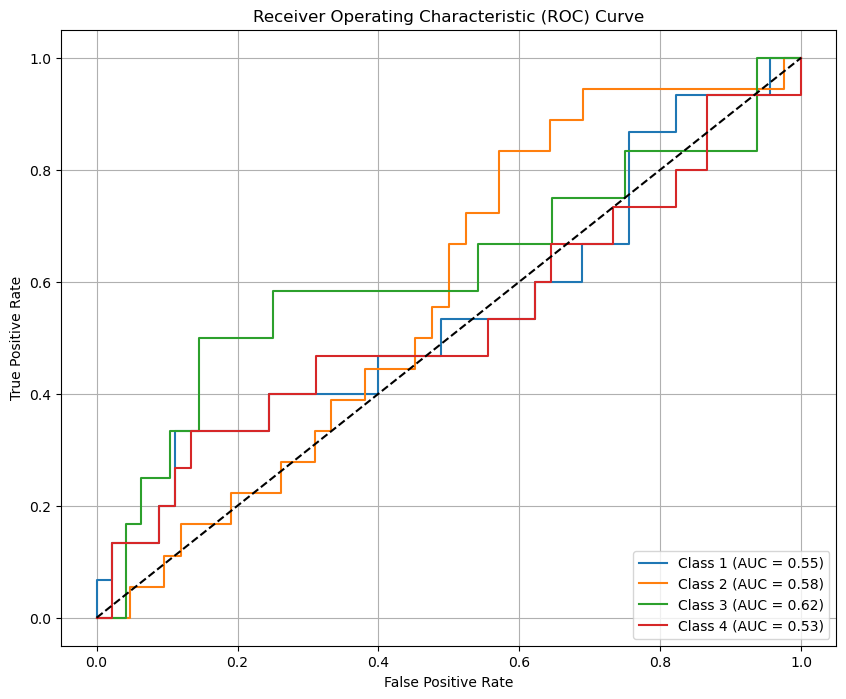

In [723]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

Y_val_binarized = label_binarize(val_true, classes=np.arange(num_classes))

val_probabilities = NN.feedForward(X_val)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val_binarized[:, i], val_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
     

The ROC curve illustrates the model’s classification performance across four output classes using the True Positive Rate (TPR) plotted against the False Positive Rate (FPR). A one-vs-rest evaluation strategy is employed to assess the model’s ability to distinguish each class from the others. Among the four classes, Class 3 demonstrates the strongest performance, with an AUC of 0.62, indicating a slightly better-than-random ability to correctly identify instances of this class.

Class 2 follows with an AUC of 0.58, showing modest predictive power, though still far from a reliable classification. Class 1 achieves an AUC of 0.55, which is only marginally better than random guessing (AUC = 0.5), suggesting limited discriminative capability for this class. Class 4 has the lowest AUC of 0.53, reflecting very weak classification performance, barely above chance level.

The dotted diagonal line in the plot represents the performance of a random classifier. Ideally, the ROC curves should bow toward the top-left corner of the graph, which indicates high true positive rates and low false positive rates. In this case, none of the curves reach that ideal region, and most hover close to the diagonal, signifying that the model struggles to distinguish between the classes with high confidence.

These results suggest that the model's current configuration does not generalize well across all classes. The relatively low AUC values point to underfitting or insufficient feature representation, and improving class-specific performance may require better feature engineering, class rebalancing, or further tuning of training parameters.